In [743]:
'''
This script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.
Then it plugs that in to the numerical simulations and runs it 

Then I graph the actual data with the optimal simulated data together to compare
'''

'\nThis script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.\nThen it plugs that in to the numerical simulations and runs it \n\nThen I graph the actual data with the optimal simulated data together to compare\n'

In [744]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
import numba as nb
from numba import njit
from operator import itemgetter

wheel = dv.ColorWheel()

In [745]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

plt.style.use('cashaback_dark')

In [746]:
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Exp1\\')
PATH = os.getcwd()
SAVE_PATH = PATH+'Group_Figures\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
os.chdir('D:\Subject_Data\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Figures_Pull_List_Control.txt", "r") as pull_file:
    analysis_pull_list_control = pull_file.read().splitlines()
with open(PATH+"\\Figures_Pull_List_Task.txt", "r") as pull_file:
    analysis_pull_list_task = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
NUM_SUBJECTS = len(figures_pull_list)
task_name = 'Seth_MatchPennies_Agent_Exp1'

In [747]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.dark_blue
box_color2 = wheel.dark_red
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

### Functions

In [748]:
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              'figure.facecolor': 'black',
              'axes.facecolor' : 'black'
              }
    plt.rcParams.update(params)

In [749]:
def jitter(arr, data):
    if data.ndim >1:
        arr = np.tile(arr,(np.shape(data)[0],1))
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    else:
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    return arr

In [750]:
#%% Double Box plot with dots Function
def double_boxplot(X_locations, Y_locations, data1,data2, xlab, ylab, title, savename, save = False):
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    plt.figure(dpi = 125, figsize = (8,4))
    box_widths = 0.3
    X_locations = X_locations
    Y_locations = Y_locations
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    total = np.concatenate((data1, data2))
    ax.plot(jitter(X_locations+box_widths/2,np.shape(data1)).T, data1.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    ax.plot(jitter(X_locations-box_widths/2, np.shape(data2)).T, data2.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    #bplot two  #block number, dyad, right/left
    ax.boxplot(data1, positions=X_locations+box_widths/2, patch_artist=True, boxprops = two_props, whiskerprops = two_whisk, 
                capprops = two_cap, medianprops = two_median, showfliers=False, widths = box_widths)
    #bplot three
    ax.boxplot(data2, positions = X_locations-box_widths/2, patch_artist=True, boxprops = three_props, whiskerprops = three_whisk,
                capprops = three_cap, medianprops=three_median, showfliers = False, widths = box_widths)
    ax.set_xticks(X_locations)
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(Y_locations)
    ax.set_yticklabels(Y_locations) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    
    labels = ["Indecisions", "Incorrect Decisions"]
    colors = [wheel.dark_blue, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+save_path+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

In [751]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_blue,wheel.dark_red]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)


In [752]:
def combine_sd(n1,n2,avg1,avg2,sd1,sd2):
    ans = np.sqrt((((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-1)) + ((n1*n2*(avg1-avg2)**2)/((n1+n2)*(n1+n2-1))))
    return ans

In [753]:
def combined_sd(n1,n2,avg1,avg2,sd1,sd2):
    avg = (n1*avg1 + n2*avg2)/(n1+n2)
    ans = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2 + n1(avg1-avg)**2 + n2*(avg2-avg)**2))

In [754]:
def combine_sd1(n1,n2,sd1,sd2):
    ans = np.sqrt(sd1**2/n1 + sd2**2/n2)
    return ans

### Pickle

Pickle Load Control Tasks


In [755]:
coincidence_trials = 50
reaction_trials = 50
interval_trials = 50
# ---------------Controls-------------------------
player_reaction_decision_array = np.empty((NUM_SUBJECTS, reaction_trials))
agent_reaction_decision_array = np.empty((NUM_SUBJECTS, reaction_trials))
player_reaction_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan 
player_reaction_movement_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan
reaction_trial_start = np.zeros((NUM_SUBJECTS,reaction_trials))*np.nan 
coincidence_trial_start = np.zeros((NUM_SUBJECTS, coincidence_trials))*np.nan
coincidence_reach_time = np.zeros((NUM_SUBJECTS, coincidence_trials))*np.nan
interval_trial_start = np.zeros((NUM_SUBJECTS, interval_trials))*np.nan
interval_reach_time = np.zeros((NUM_SUBJECTS, interval_trials))*np.nan

for i in range(NUM_SUBJECTS):
    subname = figures_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    reaction_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_reaction_trial_start.pkl', 'rb'))
    player_reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_time.pkl', 'rb'))
    player_reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_movement_time.pkl', 'rb'))
    player_reaction_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_decision_array.pkl', 'rb'))
    agent_reaction_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_agent_reaction_decision_time.pkl', 'rb'))
    reaction_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_reaction_trial_start.pkl', 'rb'))
    interval_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_interval_trial_start.pkl', 'rb'))
    interval_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_interval_reach_time.pkl', 'rb'))
    coincidence_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_coincidence_trial_start.pkl', 'rb'))
    coincidence_reach_time[i,:] =  pickle.load(open(data_path + f'{subname}_coincidence_reach_time.pkl', 'rb'))

Pickle Load Task and Washout

In [756]:
path1 = PATH+'\\'+'Sub1_Task'
task_df = pd.read_csv(path1+f'\\Sub1_TaskTrial_Table.csv')
task_df = task_df.loc[task_df['Condition type']==3] # Only get the task condition 
num_trials = int(task_df.iloc[-1]['Block_Step']) # number of trials in each block
num_blocks = int(task_df.iloc[-1]['Block_Row']/2)
tot_trials = int(num_trials*num_blocks)
trial_time = int(task_df.iloc[0]['Condition time'])
task_df_columns = len(fields_pull)
trial_table = np.empty((NUM_SUBJECTS, tot_trials, 4), int)
#----------------- TASK--------------------------------
player_task_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
player_task_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
player_task_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan
player_task_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan
agent_task_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
agent_task_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
agent_task_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan

# -------------- Washout-------------------
washout_trials = 25
player_washout_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
player_washout_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
player_washout_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
player_washout_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
agent_washout_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
agent_washout_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
agent_washout_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
agent_washout_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan

for i in range(NUM_SUBJECTS):
    subname = figures_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    #task_data[i,:,:,:,:] = pickle.load(open(data_path + f'{subname}_task_data.pkl', 'rb'))
    player_task_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_decision_time.pkl', 'rb'))
    player_task_decision_array[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_decision_array.pkl', 'rb'))
    player_task_movement_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_task_movement_time.pkl', 'rb'))
    player_task_reach_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_reach_time.pkl', 'rb'))
    agent_task_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_agent_task_decision_time.pkl', 'rb'))
    agent_task_decision_array[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_task_decision_array.pkl', 'rb'))
    agent_task_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_task_reach_time.pkl', 'rb'))
    player_washout_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_decision_time.pkl', 'rb'))
    player_washout_decision_array[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_decision_array.pkl', 'rb'))
    player_washout_movement_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_washout_movement_time.pkl', 'rb'))
    player_washout_reach_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_reach_time.pkl', 'rb'))
    agent_washout_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_agent_washout_decision_time.pkl', 'rb'))
    agent_washout_decision_array[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_washout_decision_array.pkl', 'rb'))
    agent_washout_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_washout_reach_time.pkl', 'rb'))

### Calculations

#### Calculations (Control)

Reaction and Reaction Movement Time

In [757]:
player_reaction_time

array([[570., 417., 289., 319., 315., 346., 333., 315., 356., 457., 243.,
        247., 258., 288., 307., 293., 269., 306., 275., 292., 251., 319.,
        268., 295., 326., 261., 314., 258., 303., 294., 275., 328., 276.,
        286., 264., 249., 270., 271., 257., 277., 239., 312., 261., 255.,
        266., 279., 320., 301., 260., 285.],
       [497., 329., 334., 259., 300., 297., 292., 302., 299., 327., 325.,
        305., 338., 286., 275., 293., 285., 344., 346., 313., 271., 315.,
        318., 298., 283., 300., 330., 299., 349., 314., 338., 337., 335.,
        270., 294., 314., 309., 324., 308., 302., 308., 325., 308., 284.,
        309., 270., 291., 350., 316., 316.],
       [387., 266., 323., 389., 351., 327., 304., 343., 309., 362., 309.,
        343., 272., 263., 292., 323., 264., 328., 313., 338., 378., 346.,
        283., 308., 320., 294., 313., 344., 451., 316., 325., 326., 390.,
        319., 410., 359., 352., 390., 293., 294., 327., 380., 280., 290.,
        352., 282., 37

In [758]:
#%% Calculate RT means and sds
player_reaction_time = np.where(player_reaction_time<200,np.nan,player_reaction_time) # Anytime someone reacted under 200 ms, replace with nan
reaction_plus_movement_time = player_reaction_time + player_reaction_movement_time
reaction_plus_movement_time_mean = np.nanmean(reaction_plus_movement_time, axis = 1)
reaction_plus_movement_time_sd = np.nanstd(reaction_plus_movement_time,axis=1)
player_reaction_movement_time_mean = np.nanmean(player_reaction_movement_time[:,10:], axis = 1)
player_reaction_movement_time_sd = np.nanstd(player_reaction_movement_time[:,10:], axis = 1)
player_reaction_time_mean = np.nanmean(player_reaction_time[:,10:], axis = 1)
player_reaction_time_median = np.nanmedian(player_reaction_time[:,10:], axis = 1)
player_reaction_time_sd = np.nanstd(player_reaction_time[:,10:], axis = 1)


In [759]:
player_reaction_time_mean


array([279.95 , 309.875, 330.3  , 339.125, 324.675, 315.05 , 314.875])

In [760]:
player_reaction_movement_time_mean + player_reaction_time_mean

array([414.575, 424.35 , 454.   , 579.975, 420.725, 436.775, 475.075])

Coincidence Timing

In [761]:
coincidence_reach_time_mean = np.nanmean(coincidence_reach_time[:,10:], axis=1)
coincidence_reach_time_sd =  np.nanstd(coincidence_reach_time[:,10:], axis=1)

Interval Timing

In [762]:
interval_reach_time_mean = np.nanmean(interval_reach_time[:,10:], axis=1)
interval_reach_time_sd =  np.nanstd(interval_reach_time[:,10:], axis=1)

#### Calculations (TASK)

Indecisions, Wins, Incorrects

In [763]:
# Win, Loss, Indecision counts
agent_task_decision_array = np.where(agent_task_decision_array == 2,-1,agent_task_decision_array) # Make sure agent_task_decision_array replaces 2 with -1 from the first pilot
player_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
player_wins = np.zeros((NUM_SUBJECTS, num_blocks))
player_incorrects = np.zeros((NUM_SUBJECTS,num_blocks))
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        player_indecisions[i,j] = np.count_nonzero(player_task_decision_array[i,j,:] == 0)
        player_wins[i,j] = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == 1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == -1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == 0))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == 0))
        player_incorrects[i,j] = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == -1))
        player_incorrects[i,j] += np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == 1))
perc_player_indecisions = (player_indecisions / num_trials)*100
perc_player_wins = (player_wins / num_trials)*100
perc_player_incorrects = (player_incorrects/num_trials)*100

Experiment reach and decision times

In [764]:
# Actual trials
agent_mean_task_reach_time = np.nanmean(agent_task_reach_time,axis = 2)
agent_median_reach_time = np.nanmedian(agent_task_reach_time,axis = 2)
agent_sd_task_reach_time = np.nanstd(agent_task_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_task_decision_time, axis =2)
agent_median_decision_time = np.nanmedian(agent_task_decision_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_task_decision_time, axis =2)
player_mean_task_reach_time = np.nanmean(player_task_reach_time,axis=2)
player_median_reach_time = np.nanmedian(player_task_reach_time,axis=2)
player_sd_task_reach_time = np.nanstd(player_task_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_task_decision_time,axis=2)
player_median_decision_time = np.nanmedian(player_task_decision_time,axis=2)
player_sd_decision_time = np.nanstd(agent_task_reach_time,axis = 2)

player_task_mean_movement_time = np.mean(player_mean_task_reach_time - player_mean_decision_time,axis=1)

Reach Times on Indecisions

In [765]:
#%% Find agent reach times for player indecisions
agent_task_decision_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_mean_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
indecision_index = np.argwhere(player_task_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_task_decision_time_on_indecisions[i,j,k] = agent_task_decision_time[i,j,k]
    player_task_reach_time_on_indecisions[i,j,k] = player_task_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_task_decision_time[i,j,k]
    c+=1

agent_mean_task_reach_time_on_indecisions = np.nanmean(agent_task_decision_time_on_indecisions,axis=2)
player_mean_task_reach_time_on_indecisions = np.nanmean(player_task_reach_time_on_indecisions,axis=2)
player_mean_left_time_on_indecisions = np.nanmean(player_left_time_on_indecisions,axis=2)



Gamble and reaction calculations

In [766]:
# Gamble arrays
gamble_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_reach_time_gambles = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_decision_time_gambles = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
# Reaction arrays
reaction_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
reaction_reach_target_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_reach_time_reactions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_decision_time_reactions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan

# Wins, indecisiosn, incorrects arrays
gamble_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_wins = np.zeros((NUM_SUBJECTS, num_blocks))
gamble_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
gamble_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_wins = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
total_gambles = np.zeros((NUM_SUBJECTS,num_blocks))
total_reactions = np.zeros((NUM_SUBJECTS,num_blocks))
total_did_not_leave = np.zeros((NUM_SUBJECTS,num_blocks))

for i in range(NUM_SUBJECTS): # Need this for loop for reaction time i think... maybe not but whatever it works
    temp_player_reaction_time =  player_reaction_time_mean[i] - 2*player_reaction_time_sd[i]
    gamble_index = np.argwhere((player_task_decision_time[i,:,:]-agent_task_decision_time[i,:,:])<=temp_player_reaction_time)
    reaction_index = np.argwhere((player_task_decision_time[i,:,:]-agent_task_decision_time[i,:,:])>temp_player_reaction_time)
    did_not_leave_start_index = np.argwhere(np.isnan(player_task_decision_time[i,:,:]))
    print(np.shape(gamble_index))
    print(np.shape(reaction_index))
    for j,k in gamble_index:
        gamble_decision_time[i,j,k] = player_task_decision_time[i,j,k]
        gamble_reach_target_time[i,j,k] = player_task_reach_time[i,j,k]
        agent_task_reach_time_gambles[i,j,k] = agent_task_reach_time[i,j,k]
        agent_task_decision_time_gambles[i,j,k] = agent_task_decision_time[i,j,k]
        # Calculate gamble wins
        if player_task_decision_array[i,j,k] == 1 and (agent_task_decision_array[i,j,k] == 1 or agent_task_decision_array[i,j,k] == 0):
            gamble_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == -1 and (agent_task_decision_array[i,j,k] == -1 or agent_task_decision_array[i,j,k] == 0):
            gamble_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == 0:
            gamble_indecisions[i,j] += 1
        elif player_task_decision_array[i,j,k]*agent_task_decision_array[i,j,k] == -1:
            gamble_incorrects[i,j] += 1
        else:
            print('none')
        total_gambles[i,j]+=1
    for j,k in reaction_index:
        reaction_decision_time[i,j,k] = player_task_decision_time[i,j,k]
        reaction_reach_target_time[i,j,k] = player_task_reach_time[i,j,k]
        agent_task_reach_time_reactions[i,j,k] = agent_task_reach_time[i,j,k]
        agent_task_decision_time_reactions[i,j,k] = agent_task_decision_time[i,j,k]
        # Calculate reaction wins
        if player_task_decision_array[i,j,k] == 1 and (agent_task_decision_array[i,j,k] == 1 or agent_task_decision_array[i,j,k] == 0):
            reaction_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == -1 and (agent_task_decision_array[i,j,k] == -1 or agent_task_decision_array[i,j,k] == 0):
            reaction_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == 0:
            reaction_indecisions[i,j] += 1
        elif player_task_decision_array[i,j,k]*agent_task_decision_array[i,j,k] == -1:
            reaction_incorrects[i,j] += 1
        else:
            print('none')
        total_reactions[i,j]+=1
            
    for j,k in did_not_leave_start_index:
        reaction_indecisions[i,j]+=1
        total_did_not_leave[i,j]+=1
perc_reactions = total_reactions/num_trials*100
perc_reaction_wins = reaction_wins/total_reactions*100 # Array division
perc_reaction_incorrects = reaction_incorrects/total_reactions*100
perc_reaction_indecisions = reaction_indecisions/total_reactions*100

perc_gambles = total_gambles/num_trials*100
perc_gamble_wins = gamble_wins/total_gambles*100
perc_gamble_incorrects = gamble_incorrects/total_gambles*100
perc_gamble_indecisions = gamble_indecisions/total_gambles*100

perc_wins_that_were_gambles = gamble_wins/player_wins *100
perc_indecisions_that_were_gambles = gamble_indecisions/player_indecisions*100
perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100

perc_wins_that_were_reactions = reaction_wins/player_wins*100
perc_indecisions_that_were_reactions = reaction_indecisions/player_indecisions*100
perc_incorrects_that_were_reactions = reaction_indecisions/player_incorrects*100


# get means
gamble_decision_time_means = np.nanmean(gamble_decision_time, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_time, axis =2 )
agent_task_decision_time_gamble_means = np.nanmean(agent_task_decision_time_gambles, axis = 2)
agent_task_decision_time_reaction_means = np.nanmean(agent_task_decision_time_reactions, axis = 2)


for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        if total_reactions[i,j]<10:
            perc_reaction_wins[i,j] = np.nan
            perc_reaction_incorrects[i,j] = np.nan
            perc_reaction_indecisions[i,j] = np.nan
            reaction_decision_time_means[i,j] = np.nan

        if total_gambles[i,j]<10:
            perc_gamble_wins[i,j] = np.nan
            perc_gamble_incorrects[i,j] = np.nan
            perc_gamble_indecisions[i,j] = np.nan
            gamble_decision_time_means[i,j] = np.nan

(335, 2)
(145, 2)
(244, 2)
(236, 2)
(271, 2)
(209, 2)
(433, 2)
(47, 2)
(217, 2)
(263, 2)
(321, 2)
(159, 2)
(172, 2)
(307, 2)


C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_42872\3634040395.py:86: RuntimeWarning: divide by zero encountered in true_divide
  perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_42872\3634040395.py:86: RuntimeWarning: invalid value encountered in true_divide
  perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_42872\3634040395.py:90: RuntimeWarning: divide by zero encountered in true_divide
  perc_incorrects_that_were_reactions = reaction_indecisions/player_incorrects*100


Wins when both decide

In [767]:
# Get agent decision array
agent_decision_array = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))
player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
agent_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_task_reach_time[i,j,k]>1500:
                agent_decision_array[i,j,k] = 0
            else:
                agent_decision_array[i,j,k] = agent_task_decision_array[i,j,k]
# Get wins when both decide
both_decide_index = np.argwhere(np.logical_and(player_task_decision_array!=0,agent_decision_array!=0))

for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_decision_array[i,j,k]*player_task_decision_array[i,j,k] == 1:
                player_both_reached_wins[i,j]+=1
            if agent_decision_array[i,j,k]*player_task_decision_array[i,j,k] == -1:
                agent_both_reached_wins[i,j]+=1
        x = np.count_nonzero(player_task_decision_array[i,j,:]!=0)
        y = np.count_nonzero(agent_decision_array[i,j,:]!=0)
        if x!= 0 and y!= 0:
            total = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
            perc_player_both_reached_wins[i,j] = (player_both_reached_wins[i,j]/total)*100



Reaction and Reaction Movement Time

In [768]:
#%% Calculate RT means and sds
player_reaction_time_mean = np.zeros(NUM_SUBJECTS)
player_reaction_time_sd = np.zeros(NUM_SUBJECTS)
player_reaction_movement_time_mean = np.zeros(NUM_SUBJECTS)
player_reaction_movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time_mean = np.zeros(NUM_SUBJECTS)
movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time = player_reaction_movement_time - player_reaction_time
interval_reach_time_mean = np.nanmean(interval_reach_time, axis=1)
interval_reach_time_sd = np.nanstd(interval_reach_time, axis =1)

# Reaction time
for i in range(NUM_SUBJECTS):
    player_reaction_time_mean[i] = np.nanmean(player_reaction_time[i,10:])
    player_reaction_time_sd[i] = np.nanstd(player_reaction_time[i,10:])
    player_reaction_movement_time_mean[i] = np.nanmean(player_reaction_movement_time[i,10:])
    player_reaction_movement_time_sd[i] = np.nanstd(player_reaction_movement_time[i,10:])
    movement_time_mean[i] = np.nanmean(movement_time[i,10:])
    movement_time_sd[i] = np.nanstd(movement_time[i,10:])


### Simulation Functions

In [769]:
#%% Simulation Function Only player Sensory Feedback
@njit 
def Simulate_Wins_Only_Player_Sensory_Feedback(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, player_target_reach_means, agent_target_reach_means,
                  player_reach_time, agent_reach_time, player_decision_time, agent_decision_time):
    # Initialize what I want to return
     # Initialize what I want to return
    player_wins = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    agent_wins = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    player_indecisions = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    agent_indecisions = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    neither_decision = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    player_decision_array = np.empty((len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_decision_array = np.empty((len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
    player_both_decided_array = np.empty((len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_both_decided_array = np.empty((len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
    player_reaction_wins = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    player_gamble_wins = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    player_gamble_losses = np.zeros((len(player_target_reach_means), len(agent_target_reach_means)))
    player_leave_target_time = np.zeros((len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
    c = -1 #decision time iterator
    # Simulation -------------------------------------------------------------
    for i in range(len(player_target_reach_means)):
        for j in range(len(agent_target_reach_means)):
            for k in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(player_reach_time[i,j,k],agent_reach_time[i,j,k])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                if (player_decision_time[i,j,k] - agent_decision_time[i,j,k] >= 0): 
                    player_reach_time[i,j,k] = player_decision_time[i,j,k] + REACTION_TIME + MOVEMENT_TIME
                    player_leave_target_time[i,j,k] = player_decision_time[i,j,k] + REACTION_TIME
                    if (player_reach_time[i,j,k]  < TRIAL_TIME and agent_reach_time[i,j,k] < TRIAL_TIME): 
                        player_wins[i,j] += 1
                        player_reaction_wins[i,j] +=1
                        player_decision_array[i,j,k] = 1
                        agent_decision_array[i,j,k] = -1
                        player_both_decided_array[i,j,k] = 1
                        agent_both_decided_array[i,j,k] = -1
                    else:
                        player_indecisions[i,j]+=1
                        player_decision_array[i,j,k] = 0
                        
                    # Know that agent didn't make an indecision because 1500-agent_dt >= 200 
                
                # if (agent_reach_time[i,j,k] >= player_reach_time[i,j,k] +REACTION_TIME and 
                #       TRIAL_TIME - player_reach_time[i,j,k] >=REACTION_TIME):
                #     agent_wins[i,j] += 1
                #     agent_reach_time[i,j,k] = player_reach_time[i,j,k] +REACTION_TIME # change decision time to 200ms after opponent
                #     player_decision_array[i,j,k] = -1
                #     agent_decision_array[i,j,k] = 1
                #     player_both_decided_array[i,j,k] = -1
                #     agent_both_decided_array[i,j,k] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                    
                # Both made it, random winner
                elif (player_reach_time[i,j,k]<TRIAL_TIME and 
                      agent_reach_time[i,j,k]<TRIAL_TIME): 
                    rand = random.random()
                    player_leave_target_time[i,j,k] = player_decision_time[i,j,k]
                    if rand>=0.5:
                        player_wins[i,j] += 1
                        player_gamble_wins[i,j]+=1
                        player_decision_array[i,j,k] = 1
                        agent_decision_array[i,j,k] = -1
                        player_both_decided_array[i,j,k] = 1
                        agent_both_decided_array[i,j,k] = -1
                    else:
                        agent_wins[i,j] += 1    
                        player_gamble_losses[i,j] += 1
                        player_decision_array[i,j,k] = -1
                        agent_decision_array[i,j,k] = 1     
                        player_both_decided_array[i,j,k] = -1
                        agent_both_decided_array[i,j,k] = 1                                                                                      
                # player didn't make it
                elif (player_reach_time[i,j,k]>= TRIAL_TIME and
                      agent_reach_time[i,j,k]<TRIAL_TIME):
                    player_leave_target_time[i,j,k] = player_decision_time[i,j,k]
                    agent_wins[i,j] += 1
                    player_indecisions[i,j] += 1
                    player_decision_array[i,j,k] = 0
                    agent_decision_array[i,j,k] = 1
                    player_both_decided_array[i,j,k] = 0
                    agent_both_decided_array[i,j,k] = 1
                # agent didn't make it
                elif (player_reach_time[i,j,k]<TRIAL_TIME and 
                      agent_reach_time[i,j,k]>=TRIAL_TIME):
                    player_leave_target_time[i,j,k] = player_decision_time[i,j,k]
                    player_wins[i,j] += 1
                    player_gamble_wins[i,j] += 1
                    agent_indecisions[i,j] += 1
                    player_decision_array[i,j,k] = 1
                    agent_decision_array[i,j,k] = 0
                    player_both_decided_array[i,j,k] = 1
                    agent_both_decided_array[i,j,k] = 0
                # Both didn't make it 
                elif (player_reach_time[i,j,k]>=TRIAL_TIME and 
                      agent_reach_time[i,j,k]>=TRIAL_TIME):
                    player_leave_target_time[i,j,k] = player_decision_time[i,j,k]
                    player_indecisions[i,j] += 1
                    agent_indecisions[i,j] += 1
                    neither_decision[i,j] += 1
                    player_decision_array[i,j,k] = 0
                    agent_decision_array[i,j,k] = 0
                    player_both_decided_array[i,j,k] = 0
                    agent_both_decided_array[i,j,k] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return player_wins, player_reaction_wins, player_gamble_wins, player_gamble_losses, agent_wins, player_indecisions, \
        agent_indecisions, player_reach_time, agent_reach_time, player_decision_time,agent_decision_time, \
        player_decision_array, agent_decision_array, player_both_decided_array, agent_both_decided_array,player_leave_target_time         

In [770]:
#%% Simulation Function Only P1 Sensory Feedback create mock data with bootstrapped reaciotn time, movement time, timing uncertainty, 
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data(TRIAL_TIME,NUM_TRIALS,player_reaction_time,MOVEMENT_TIME, 
                                                             NUM_SUBJECTS, agent_std, target_reach_means_p1, target_reach_means_agent,
                                                             p1_reach_time, agent_task_reach_time, p1_decision_time, agent_decision_time,
                                                             std_number):
    b = std_number
    # Initialize what I want to return
    p1_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_indecision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_indecision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    neither_decision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_decision_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_decision_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_both_decided_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    
    p1_reaction_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_losses = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    c = -1 #decision time iterator
    print(np.shape(target_reach_means_p1))
        # Simulation -------------------------------------------------------------
    for dt_p1 in (target_reach_means_p1):
        c=c+1
        z=-1
        for dt_agent in target_reach_means_agent:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[b,c,z,i],agent_task_reach_time[b,c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_decision_time[b,c,z,i] - agent_decision_time[b,c,z,i] >= player_reaction_time) and (agent_decision_time[b,c,z,i] + player_reaction_time + MOVEMENT_TIME < TRIAL_TIME)): # EVEN if p1 is over the trial time, if they can react in time to agent then this gets triggered
                    p1_wins[c,z] += 1
                    p1_reaction_wins[c,z] +=1
                    p1_decision_time[b,c,z,i] = agent_decision_time[b,c,z,i] + player_reaction_time # change decision time to reaction time after opponent
                    p1_reach_time[b,c,z,i] = p1_decision_time[b,c,z,i] + MOVEMENT_TIME 
                    p1_decision_array[b,c,z,i] = 1
                    agent_decision_array[b,c,z,i] = -1
                    p1_both_decided_array[b,c,z,i] = 1
                    agent_both_decided_array[b,c,z,i] = -1
                    if p1_reach_time[b,c,z,i]>TRIAL_TIME:
                        print('ERROR')
                    # Know that agent didn't make an indecision because 1500-agent_dt >= 200 
                
                # if (agent_task_reach_time[b,c,z,i] >= p1_reach_time[b,c,z,i] +player_reaction_time and 
                #       TRIAL_TIME - p1_reach_time[b,c,z,i] >=player_reaction_time):
                #     agent_wins[c,z] += 1
                #     agent_task_reach_time[b,c,z,i] = p1_reach_time[b,c,z,i] +player_reaction_time # change decision time to 200ms after opponent
                #     p1_decision_array[b,c,z,i] = -1
                #     agent_decision_array[b,c,z,i] = 1
                #     p1_both_decided_array[b,c,z,i] = -1
                #     agent_both_decided_array[b,c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[b,c,z,i]<TRIAL_TIME and
                      agent_task_reach_time[b,c,z,i]<TRIAL_TIME): 
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_gamble_wins[c,z]+=1
                        p1_decision_array[b,c,z,i] = 1
                        agent_decision_array[b,c,z,i] = -1
                        p1_both_decided_array[b,c,z,i] = 1
                        agent_both_decided_array[b,c,z,i] = -1
                    else:
                        agent_wins[c,z] += 1    
                        p1_gamble_losses[c,z] += 1
                        p1_decision_array[b,c,z,i] = -1
                        agent_decision_array[b,c,z,i] = 1     
                        p1_both_decided_array[b,c,z,i] = -1
                        agent_both_decided_array[b,c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[b,c,z,i]>= TRIAL_TIME and
                      agent_task_reach_time[b,c,z,i]<TRIAL_TIME):
                    agent_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 0
                    agent_decision_array[b,c,z,i] = 1
                    p1_both_decided_array[b,c,z,i] = 0
                    agent_both_decided_array[b,c,z,i] = 1
                # agent didn't make it
                elif (p1_reach_time[b,c,z,i]<TRIAL_TIME and 
                      agent_task_reach_time[b,c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p1_gamble_wins[c,z] += 1
                    agent_indecision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 1
                    agent_decision_array[b,c,z,i] = 0
                    p1_both_decided_array[b,c,z,i] = 1
                    agent_both_decided_array[b,c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[b,c,z,i]>=TRIAL_TIME and 
                      agent_task_reach_time[b,c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    agent_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 0
                    agent_decision_array[b,c,z,i] = 0
                    p1_both_decided_array[b,c,z,i] = 0
                    agent_both_decided_array[b,c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, agent_wins, p1_indecision, agent_indecision, p1_reach_time, agent_task_reach_time, p1_decision_time,agent_decision_time, \
        p1_decision_array, agent_decision_array, p1_both_decided_array, agent_both_decided_array         

In [771]:
#%% Calculate both decided wins
@njit
def calc_both_decide_wins(NUM_TRIALS, target_reach_means_p1,target_reach_means_agent,
                          p1_decision_array,
                          agent_decision_array, 
                          p1_both_decided_array, 
                          agent_both_decided_array):
    p1_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
       
    # p1_both_decided_array = p1_decision_array #decision array
    # agent_both_decided_array = agent_decision_array     
    p1_indecision_index = np.argwhere(p1_decision_array == 0)
    agent_indecision_index = np.argwhere(agent_decision_array == 0)
      # Create arrays for when both decide 
      #Replace all 0's (indecisions) with nans
    for i,j,k in p1_indecision_index:
        p1_both_decided_array[i,j,k] = np.nan
        agent_both_decided_array[i,j,k] = np.nan
    for i,j,k in agent_indecision_index:
       p1_both_decided_array[i,j,k] = np.nan
       agent_both_decided_array[i,j,k] = np.nan
    
    # Count wins for each when both decide
    for i in range(len(target_reach_means_p1)):
        for j in range(len(target_reach_means_agent)):
            for k in range(NUM_TRIALS):
                if p1_both_decided_array[i,j,k]==1 and agent_both_decided_array[i,j,k] == -1:
                    p1_both_decided_wins[i,j] += 1
                    # if np.isnan(p1_both_decided_array[i]):
                    #     print('error')
                    #print(f"Right wins on correct choice: {decision_array_R[i,j,k]}, {decision_array_L[i,j,k]}")
                # Prey won for correct choice
                elif agent_both_decided_array[i,j,k]==1 and p1_both_decided_array[i,j,k] == -1:
                    agent_both_decided_wins[i,j] += 1
                    
            x = np.count_nonzero(~np.isnan(p1_both_decided_array[i,j,:]))
            y = np.count_nonzero(~np.isnan(agent_both_decided_array[i,j,:]))
            if x != 0 and y != 0:
                total = np.count_nonzero(np.logical_and(p1_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
                p1_perc_both_decided_wins[i,j] = (p1_both_decided_wins[i,j] / total)*100
                agent_perc_both_decided_wins[i,j] = (agent_both_decided_wins[i,j] / total)*100
            else:
                p1_perc_both_decided_wins[i,j] = np.nan
                agent_perc_both_decided_wins[i,j] = np.nan
        
    return p1_perc_both_decided_wins, agent_perc_both_decided_wins


### Plot Functions

In [772]:
def plot_optimals(perc_optimal_wins, perc_optimal_indecisions, optimal_mean_decision_time,
                  perc_player_wins,perc_player_indecisions,player_mean_decision_time,
                  target_reach_means_agent,condition_times, title = None):
    
    colors = [wheel.rak_blue,wheel.rak_orange,wheel.rak_red]

    vlines = False

    fig,axs = plt.subplots(2, dpi = 150, figsize = (8,8))
    # PLOT OPTIMAL WINS
    axs[0].plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = colors[0], label = 'Wins',markersize = 10, markerfacecolor = "None")
    # Plot data
    axs[0].scatter(condition_times,perc_player_wins, marker = 'v',s=75 ,c = wheel.dark_blue,alpha=1, zorder = 199)
    if vlines:
        axs[0].plot([1000,1000], (-5,perc_optimal_wins[6]), c= 'w',zorder=1)
        axs[0].plot([1100,1100], (-5,perc_optimal_wins[10]), c= 'w',zorder=1)
        axs[0].plot([1200,1200], (-5,perc_optimal_wins[14]), c= 'w',zorder=1)


    axs[0].spines['left'].set_color(colors[0])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_ylim(-5,105)
    axs[0].set_yticks(np.arange(0,110,25))
    axs[0].set_ylabel('Participant \nWins (%)', fontweight = 'bold', fontsize = 16)
    axs[0].set_xlabel("Agent Mean Movement Onset Time (ms)", fontweight = 'bold', fontsize = 16)
    axs[0].set_title('Optimal Wins and Mean Decision Time', c = 'w', fontweight = 'bold', fontsize = 17)

    # RIGHT AXIS
    ax2 = axs[0].twinx()
    # Plot optimal decision time
    ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=colors[1], ms = 10, zorder = 1, markerfacecolor = "None")
    # Plot Data
    ax2.scatter(condition_times, player_mean_decision_time,marker = 'v',s=75,  c= wheel.orange, alpha = 1, zorder = 101)

    ax2.set_yticks(np.arange(400,1600,200))
    ax2.set_yticklabels(np.arange(400,1600,200))
    ax2.set_ylim(600,1400)
    ax2.spines['right'].set_color(wheel.rak_orange)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('Participant Mean \nDecision Time (ms)', fontweight = 'bold')
    # axs[0].text(1000 - 15,perc_optimal_indecisions[6]+4,f'{perc_optimal_indecisions[6]:0.0f}')
    # axs[0].text(1100 - 15,perc_optimal_indecisions[10]+4,f'{perc_optimal_indecisions[10]:0.0f}')
    # axs[0].text(1200 - 7,perc_optimal_indecisions[14]+4,f'{perc_optimal_indecisions[14]:0.0f}')
    for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(2)
        axs[0].spines[axis].set_linewidth(2)
        axs[1].spines[axis].set_linewidth(2)


    # BOTTOM SUBPLOT
    # Plot optimal indecisions
    axs[1].plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.rak_red, label = 'Indecisions',markersize = 10, markerfacecolor = "None")
    # Plot data indecisions
    axs[1].scatter(condition_times,perc_player_indecisions, marker = 'v',s=75, c = wheel.dark_red,alpha=1, zorder = 100) 
    axs[1].plot((condition_times,condition_times),(perc_optimal_indecisions1,perc_player_indecisions), c= wheel.white,alpha=0.7)
    # if vlines:
    #     axs[1].plot([1000,1000], (-5,perc_optimal_indecisions[6]), c= 'w',zorder=1)
    #     axs[1].plot([1100,1100], (-5,perc_optimal_indecisions[10]), c= 'w',zorder=1)
    #     axs[1].plot([1200,1200], (-5,perc_optimal_indecisions[14]), c= 'w',zorder=1)

    axs[1].set_ylim(-5,105)
    axs[1].set_yticks(np.arange(0,110,25))

    axs[1].set_ylabel('Participant \nIndecisions (%)', fontweight = 'bold', fontsize = 16)
    axs[1].spines['left'].set_visible(True)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    #axs[0].set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
    axs[1].set_xlabel("Agent Mean Movement Onset Time (ms)", fontweight = 'bold', fontsize= 16)
    axs[1].set_title('Optimal Indecisions', c = 'w', fontweight = 'bold', fontsize = 17)
    # ax.set_title(f'Probabilistic Model Results \n Sub{sub_num+1}, Agent STD = {sig2}')

    fig.suptitle(f'Probabilistic Model Results \n {title}, Agent STD = {sig2}', c= 'white', fontsize = 20, fontweight = 'bold')
    plt.subplots_adjust(hspace=0.6)
    labels = ['Wins', 'Mean Decision Team']
    leg_colors = [colors[0],colors[1]]
    dv.Custom_Legend(axs[0], labels, leg_colors, ncol = 1,columnspacing = 1.5,fontsize = 16)
    # plt.savefig(f'C:\\Users\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\Qualifying Exam Thangs\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}',
    #             dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

### Run Simulation with subject data (Individual)


In [773]:
agent_means = agent_mean_decision_time
agent_stds = agent_sd_decision_time
optimal_decision_times = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),num_blocks))
optimal_rewards = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),num_blocks))
reaction_times = np.zeros((NUM_SUBJECTS))
movement_times = np.zeros((NUM_SUBJECTS))
reaction_uncertainty = np.zeros((NUM_SUBJECTS))
timing_uncertainty = np.zeros((NUM_SUBJECTS))
movement_uncertainty = np.zeros((NUM_SUBJECTS))
total_uncertainty = np.zeros((NUM_SUBJECTS))
#%% Constant Variables
NUM_SUBJECTS = 1
TRIAL_TIME = 1500
NUM_TRIALS = 10000
AGENT_MOVEMENT_TIME = 150
# Simulation arrays
# For norm.rvs
interval = 25
start_time = 300
end_time = 1300
total_times = int((end_time - start_time) / interval)+1
player_target_reach_means = np.arange(start_time, end_time+interval, interval)
agent_target_reach_means = np.arange(500,1500,25)
agent_decision_time_means = agent_target_reach_means - AGENT_MOVEMENT_TIME
# For storage of simulated reach times
player_reach_times = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))
agent_reach_times = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))

player_decision_array = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))
agent_decision_array = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))
player_both_decided_array = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))
agent_both_decided_array = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means),NUM_TRIALS))

 # Initialize what I want to return
player_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
agent_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
player_indecision = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
agent_indecision = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
neither_decision = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))

player_decision_array = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
agent_decision_array = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
player_both_decided_array = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
agent_both_decided_array = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
player_reach_times_f = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
agent_reach_times_f = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
player_decision_times_f = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
agent_decision_times_f = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))
player_leave_target_time_f = np.empty((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means), NUM_TRIALS))

player_reaction_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
player_gamble_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
player_gamble_losses = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))

p1_avg_dt = np.zeros((NUM_SUBJECTS,num_blocks,len(player_target_reach_means), len(agent_target_reach_means)))
p1_avg_dt_final = np.zeros((NUM_SUBJECTS,num_blocks,len(player_target_reach_means)))
p1_avg_lt = np.zeros((NUM_SUBJECTS,num_blocks,len(player_target_reach_means), len(agent_target_reach_means)))
p1_avg_lt_final = np.zeros((NUM_SUBJECTS,num_blocks,len(player_target_reach_means)))
 
optimal_mean_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))
optimal_mean_leave_time = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))
optimal_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))
optimal_wins = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))
optimal_incorrects = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))

p1_perc_both_decided_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
agent_perc_both_decided_wins = np.zeros((NUM_SUBJECTS,len(agent_stds[0,:]),len(player_target_reach_means), len(agent_target_reach_means)))
perc_optimal_both_decided_wins = np.zeros((NUM_SUBJECTS,num_blocks,len(agent_target_reach_means)))

for i in range(NUM_SUBJECTS):
    reaction_times[i] = (player_reaction_time_mean[i]) - 2*(player_reaction_time_sd[i])
    movement_times[i] = (player_task_mean_movement_time[i]) - (player_reaction_movement_time_sd[i])
    movement_uncertainty[i] = (player_reaction_movement_time_sd[i]) # NOT reaction+movement time, just the movement time in the reaction control condition
    reaction_uncertainty[i] = (player_reaction_time_sd[i])
    timing_uncertainty[i] = (coincidence_reach_time_sd[i])
    total_uncertainty[i] = np.sqrt(movement_uncertainty[i]**2 + reaction_uncertainty[i]**2 + timing_uncertainty[i]**2)
    total_uncertainty[i] = 100
    # reaction_movement_uncertainty[i] = 110
    # movement_uncertainty[i] = 50
        #Start and end decision time for player 1
    for j in range(num_blocks):
        c=-1
        for dt_player in (player_target_reach_means):
            c=c+1
            z=-1
            for dt_agent in agent_target_reach_means:
                z=z+1
                player_reach_times[i,j,c,z,:] = norm.rvs(dt_player, total_uncertainty[i], size = NUM_TRIALS)
                agent_reach_times[i,j,c,z,:] = norm.rvs(dt_agent, agent_stds[i,j], size = NUM_TRIALS)
        player_decision_times = player_reach_times - movement_times[i]
        agent_decision_times = agent_reach_times - AGENT_MOVEMENT_TIME
        
        player_wins[i,j,:,:], player_reaction_wins[i,j,:,:], player_gamble_wins[i,j,:,:], player_gamble_losses[i,j,:,:], agent_wins[i,j,:,:], player_indecision[i,j,:,:], agent_indecision[i,j,:,:], \
        player_reach_times_f[i,j,:,:,:], agent_reach_times_f[i,j,:,:], player_decision_times_f[i,j,:,:,:], agent_decision_times_f[i,j,:,:,:], player_decision_array[i,j,:,:,:], agent_decision_array[i,j,:,:,:], \
        player_both_decided_array[i,j,:,:,:], agent_both_decided_array[i,j,:,:,:],player_leave_target_time_f[i,j,:,:,:] = Simulate_Wins_Only_Player_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, reaction_times[i],movement_times[i],
                                                                                                        player_target_reach_means, agent_target_reach_means, 
                                                                                                        player_reach_times[i,j,:,:,:], agent_reach_times[i,j,:,:,:],
                                                                                                        player_decision_times[i,j,:,:,:],agent_decision_times[i,j,:,:])
        # Calculate both decided wins
        p1_perc_both_decided_wins[i,j,:,:], agent_perc_both_decided_wins[i,j,:,:] = \
            calc_both_decide_wins(NUM_TRIALS,player_target_reach_means, agent_target_reach_means, player_decision_array[i,j,:,:,:], agent_decision_array[i,j,:,:,:],  
                                  player_both_decided_array[i,j,:,:,:],agent_both_decided_array[i,j,:,:,:])
        # Caluclate mean decision times

        #%% Find optimal control policy 
        # Find average of actual decision times
        for a in range(len(player_target_reach_means)):
            for b in range(len(agent_target_reach_means)):
                p1_avg_dt[i,j,a,b] = np.mean(player_decision_times_f[i,j,a,b,:])
                p1_avg_lt[i,j,a,b] = np.mean(player_leave_target_time_f[i,j,a,b,:])
        for a in range(len(player_target_reach_means)):
            p1_avg_dt_final[i,j,a] = np.mean(p1_avg_dt[i,j,a,:])  
            p1_avg_lt_final[i,j,a] = np.mean(p1_avg_lt[i,j,a,:])  
            
        
        for b in range(len(agent_target_reach_means)):
            max_win_index = np.argmax(player_wins[i,j,:,b])
            optimal_mean_decision_time[i,j,b] = p1_avg_dt[i,j,max_win_index,b]
            optimal_mean_leave_time[i,j,b] = p1_avg_lt[i,j,max_win_index,b]
            optimal_indecisions[i,j,b] = player_indecision[i,j,max_win_index,b]
            optimal_wins[i,j,b] = player_wins[i,j,max_win_index,b]
            # optimal_incorrects[j] = p1_incorrects[max_win_index,j] Need to implement optimal incorrects
            perc_optimal_both_decided_wins[i,j,b] = p1_perc_both_decided_wins[i,j,max_win_index,b]
perc_optimal_wins = optimal_wins/NUM_TRIALS*100
perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100



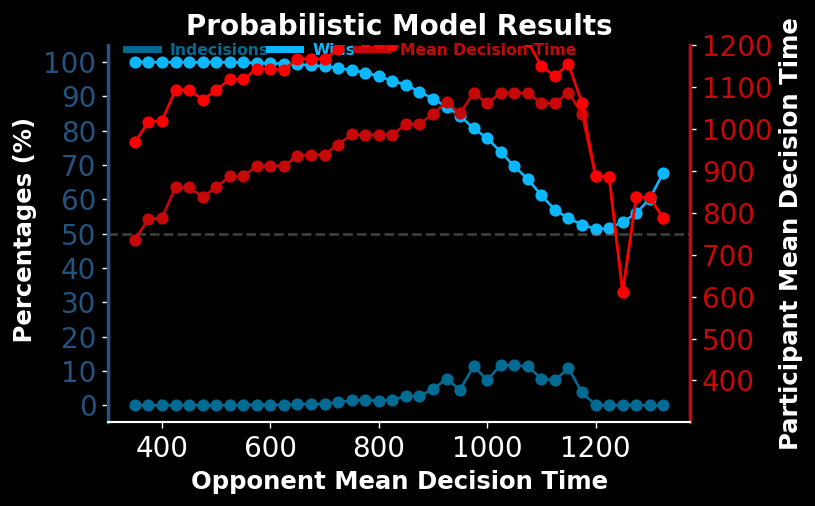

In [774]:
#%% All on one, with vertical lines on the selected mean decision time
plt.figure(dpi=125)
ax = plt.subplot()
ax.plot(agent_target_reach_means-AGENT_MOVEMENT_TIME,perc_optimal_indecisions[0,0,:],'-o', c = wheel.dark_blue2, label = 'Indecisions')
ax.plot(agent_target_reach_means-AGENT_MOVEMENT_TIME,perc_optimal_wins[0,0,:],'-o', c = wheel.light_blue, label = 'Wins')
#ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
# ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
# ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
ax.set_ylim(-5,105)
ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
ax.set_xlabel("Opponent Mean Decision Time")
ax.set_ylabel(' Percentages (%)')
ax.spines['left'].set_color(wheel.dark_blue)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()
ax2.plot(agent_target_reach_means-AGENT_MOVEMENT_TIME,optimal_mean_decision_time[i,0,:],'-o', c=wheel.dark_red)
ax2.plot(agent_target_reach_means-AGENT_MOVEMENT_TIME,optimal_mean_leave_time[i,0,:],'-o', c=wheel.seth_red)

ax2.set_yticks(np.arange(400,1600,100))
ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
ax2.set_ylim(300,1200)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(wheel.dark_red)
ax2.spines['right'].set_linewidth(2)
ax2.set_ylabel('Participant Mean Decision Time')
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
ax.set_title('Probabilistic Model Results')
labels = ['Indecisions', 'Wins','Mean Decision Time']
colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
#plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

In [775]:

for sub_num in subject_number:
    p1_std = player_reaction_movement_time_sd[sub_num]+coincidence_reach_time_sd[sub_num]
    print(f"Reaction Time Mean = {player_reaction_time_mean[sub_num]}")
    print(f'Coincidence Reach Time Mean = {coincidence_reach_time_mean[sub_num]}')
    print(f'Overall Uncertainty = {p1_std}')
    p1_std = [p1_std]
    agent_std = [50,150]
    figs = [] # Empty list to store figures so I can change them around on the next cell
    a,b = -1,-1
    for sig1 in (p1_std):
        a+=1
        for sig2 in agent_std:
            b+=1
            #%% Constant Variables
            TRIAL_TIME = 1500
            NUM_TRIALS = 10000
            REACTION_TIME = player_reaction_time_mean[sub_num]
            MOVEMENT_TIME = player_reaction_movement_time_mean[sub_num] # NOT reaction+movement, but the movement time on the reaction test
            AGENT_MOVEMENT_TIME = 150
            #Start and end decision time for player 1
            interval = 25
            start_time1 = 1000
            end_time1 = 1650
            total_times1 = int((end_time1 - start_time1) / interval)+1
            target_reach_means_p1 = np.zeros(total_times1)
            # Start and end decision time for player 2
            start_time = 1000
            end_time = 1650
            total_times2 = int((end_time - start_time) / interval)+1
            target_reach_means_agent = np.zeros(total_times2)
            # Creating AVERAGE decision time arrays
            # To be used in the norm.rvs
            for i in range(total_times1):
                target_reach_means_p1[i] = start_time1
                start_time1 = start_time1 + interval
            for i in range(total_times2):
                target_reach_means_agent[i] = start_time
                start_time = start_time + interval
            target_reach_means_p1 = target_reach_means_p1.astype(int)
            target_reach_means_agent = target_reach_means_agent.astype(int)
            agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME
            #Decision time storage arrays
                        
            #%% Run Simulation w/ SD = 100,100
            
            c=-1
            for dt_p1 in (target_reach_means_p1):
                c=c+1
                z=-1
                for dt_agent in target_reach_means_agent:
                    z=z+1
                    # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                    # agent_task_reach_time[c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                    p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                    agent_task_reach_time[c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
            p1_decision_time = p1_reach_time - MOVEMENT_TIME
            agent_decision_time = agent_task_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


            #make response time arrays
            # for dt_p1 in tqdm(target_reach_means_p1):
            #         c=c+1
            #         z=-1
            #         for dt_agent in target_reach_means_agent:
            #             z=z+1

            #-----------------------------------------------------------------------------
            p1_wins, p1_reaction_wins, p1_gamble_wins, p1_gamble_losses, agent_wins, p1_indecision, agent_indecision, \
                p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                    p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                        target_reach_means_p1, target_reach_means_agent, 
                                                                                                        p1_reach_time, agent_task_reach_time,
                                                                                                        p1_decision_time,agent_decision_time)
            # Calculate both decided wins
            p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
                calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
            # Caluclate mean decision times
            
            #%% Find optimal control policy 
            # Find average of actual decision times
            p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
            p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
            for i in range(len(target_reach_means_p1)):
                for j in range(len(target_reach_means_agent)):
                    p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
            for i in range(len(target_reach_means_p1)):
                p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
                
            optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
            optimal_indecisions = np.zeros(len(target_reach_means_p1))
            optimal_wins = np.zeros(len(target_reach_means_p1))
            optimal_incorrects = np.zeros(len(target_reach_means_p1))
            perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
            for j in range(len(target_reach_means_agent)):
                max_win_index = np.argmax(p1_wins[:,j])
                optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
                optimal_indecisions[j] = p1_indecision[max_win_index,j]
                optimal_wins[j] = p1_wins[max_win_index,j]
                # optimal_incorrects[j] = p1_incorrects[max_win_index,j] Need to implement optimal incorrects
                perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
            perc_optimal_wins = optimal_wins/NUM_TRIALS*100
            perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

            # Pickle each subject
            subname = f'Sub{sub_num + 1}'
            data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
            pickle.dump(perc_optimal_wins, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_wins.pkl', 'wb'))
            pickle.dump(perc_optimal_indecisions, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_indecisions.pkl', 'wb'))
            pickle.dump(optimal_mean_decision_time, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_mean_decision_time.pkl', 'wb'))

            # #%% All on one, with vertical lines on the selected mean decision time
            # plt.figure(dpi=125)
            # ax = plt.subplot()
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
            # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            # ax.set_ylim(-5,105)
            # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            # ax.set_xlabel("Opponent Mean Decision Time")
            # ax.set_ylabel(' Percentages (%)')
            # ax.spines['left'].set_color(wheel.dark_blue)
            # ax.spines['left'].set_linewidth(2)
            # ax.spines['top'].set_visible(False)

            # ax2 = ax.twinx()
            # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
            # ax2.set_yticks(np.arange(400,1600,100))
            # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            # ax2.set_ylim(600,1400)
            # ax2.spines['right'].set_visible(True)
            # ax2.spines['right'].set_color(wheel.dark_red)
            # ax2.spines['right'].set_linewidth(2)
            # ax2.set_ylabel('Participant Mean Decision Time')
            # ax2.spines['left'].set_visible(False)
            # ax2.spines['top'].set_visible(False)
            # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
            # ax.set_title('Probabilistic Model Results')
            # labels = ['Indecisions', 'Wins','Mean Decision Time']
            # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
            # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            # plt.show()
            
            # Plot lines with the player means as points
            index = []
            for x in condition_times:
                index.append(np.argwhere(agent_decision_means==x))
            perc_optimal_indecisions1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_indecisions) # itemgetter gets 3 specific indecies from the thing in parentheses, in this case perc_optimal_indecisions
            perc_optimal_wins1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_wins)
            optimal_mean_decision_time1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(optimal_mean_decision_time)
            if sig2 == 50:
                player_mean_decision_time1 = player_mean_decision_time[sub_num,::2] # This takes every other index, so only the 50 std ones
                perc_player_indecisions1 = perc_player_indecisions[sub_num,::2]
                perc_player_wins1 = perc_player_wins[sub_num,::2]
                print(perc_optimal_indecisions1,perc_player_indecisions1)
            else:
                perc_player_indecisions1 = perc_player_indecisions[sub_num,1::2]
                perc_player_wins1 = perc_player_wins[sub_num,1::2]
                player_mean_decision_time1 = player_mean_decision_time[sub_num,1::2] # Same as above but starts at index of 1
                
                
            plot_optimals(perc_optimal_wins,perc_optimal_indecisions,optimal_mean_decision_time,
                          perc_player_wins1,perc_player_indecisions1,player_mean_decision_time1,target_reach_means_agent,condition_times)
            # fig,ax = plt.subplots(dpi = 125)
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions, c = wheel.dark_blue2, label = 'Indecisions')
            # ax.scatter(condition_times,perc_player_indecisions1, c = wheel.dark_blue2,alpha=0.7)    
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins, c = wheel.light_blue, label = 'Wins')
            # ax.scatter(condition_times,perc_player_wins1, c = wheel.light_blue,alpha=0.7)
            # ax.plot((condition_times,condition_times),(perc_optimal_indecisions1,perc_player_indecisions1), c= wheel.dark_blue2,alpha=0.7)
            # ax.plot((condition_times,condition_times),(perc_optimal_wins1,perc_player_wins1), c= wheel.light_blue, alpha = 0.7)
            # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            # ax.set_ylim(-5,105)
            # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            # ax.set_xlabel("Opponent Mean Decision Time")
            # ax.set_ylabel(' Percentages (%)')
            # ax.spines['left'].set_color(wheel.dark_blue)
            # ax.spines['left'].set_linewidth(2)
            # ax.spines['top'].set_visible(False)

            # ax2 = ax.twinx()
            # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time, c=wheel.dark_red)
            # ax2.scatter(condition_times, player_mean_decision_time1, c= wheel.dark_red, alpha = 0.7)
            # ax2.plot((condition_times,condition_times),(optimal_mean_decision_time1,player_mean_decision_time1), c= wheel.dark_red, alpha = 0.7)

            # c=-1
            # for x in condition_times:
            #     c+=1
            #     index = np.argwhere(target_reach_means_agent == x)
            #     index = index[0][0]
            #     print(perc_optimal_indecisions[index],perc_optimal_wins[index],optimal_mean_decision_time[index])
            #     ax.axvline(x,perc_optimal_indecisions[index],perc_player_indecisions1[c])
            #     ax.axvline(x,perc_optimal_wins[index],perc_player_wins1[c])
            #     ax2.axvline(x,optimal_mean_decision_time[index],player_mean_decision_time1[c])
                
            # ax2.set_yticks(np.arange(400,1600,100))
            # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            # ax2.set_ylim(600,1450)
            # ax2.spines['right'].set_visible(True)
            # ax2.spines['right'].set_color(wheel.dark_red)
            # ax2.spines['right'].set_linewidth(2)
            # ax2.set_ylabel('Participant Mean Decision Time')
            # ax2.spines['left'].set_visible(False)
            # ax2.spines['top'].set_visible(False)
            # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
            # ax.set_title(f'Probabilistic Model Results \n Sub{sub_num+1}, Agent STD = {sig2}')
            # labels = ['Indecisions', 'Wins','Mean Decision Time']
            # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3, columnspacing=2)
            # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            # plt.show()
            # figs.append(fig)
            
            
        
        
        #plot_list.append(ax)

NameError: name 'subject_number' is not defined

### Average everything together and run again

Average data

In [ ]:
mean_of_mean_player_reaction_time = np.mean(player_reaction_time_mean)
mean_of_mean_movement_time = np.mean(player_reaction_movement_time_mean)
mean_of_sd_player_reaction_time = np.mean(player_reaction_time_sd)
mean_of_sd_reaction_movement_time = np.mean(player_reaction_movement_time_sd)
mean_of_coincidence_timing_sd = np.mean(coincidence_reach_time_sd)
mean_indecisions_across_participants = np.mean(perc_player_indecisions,axis=0)
mean_wins_across_participants = np.mean(perc_player_wins,axis=0)
mean_of_mean_decision_time = np.mean(player_mean_decision_time,axis=0)

mean_of_perc_wins = np.mean(perc_player_wins,axis=0)
mean_of_perc_indecisions = np.mean(perc_player_indecisions,axis=0)
mean_of_player_decision_times = np.mean(player_mean_decision_time,axis=0)

Run sim with averaged data

Reaction Time Mean = 316.49583333333334
Overall Uncertainty = 106.49852334742724
(5.609999999999999, 0.13999999999999999, 0.0) [ 8.75 10.   23.75]


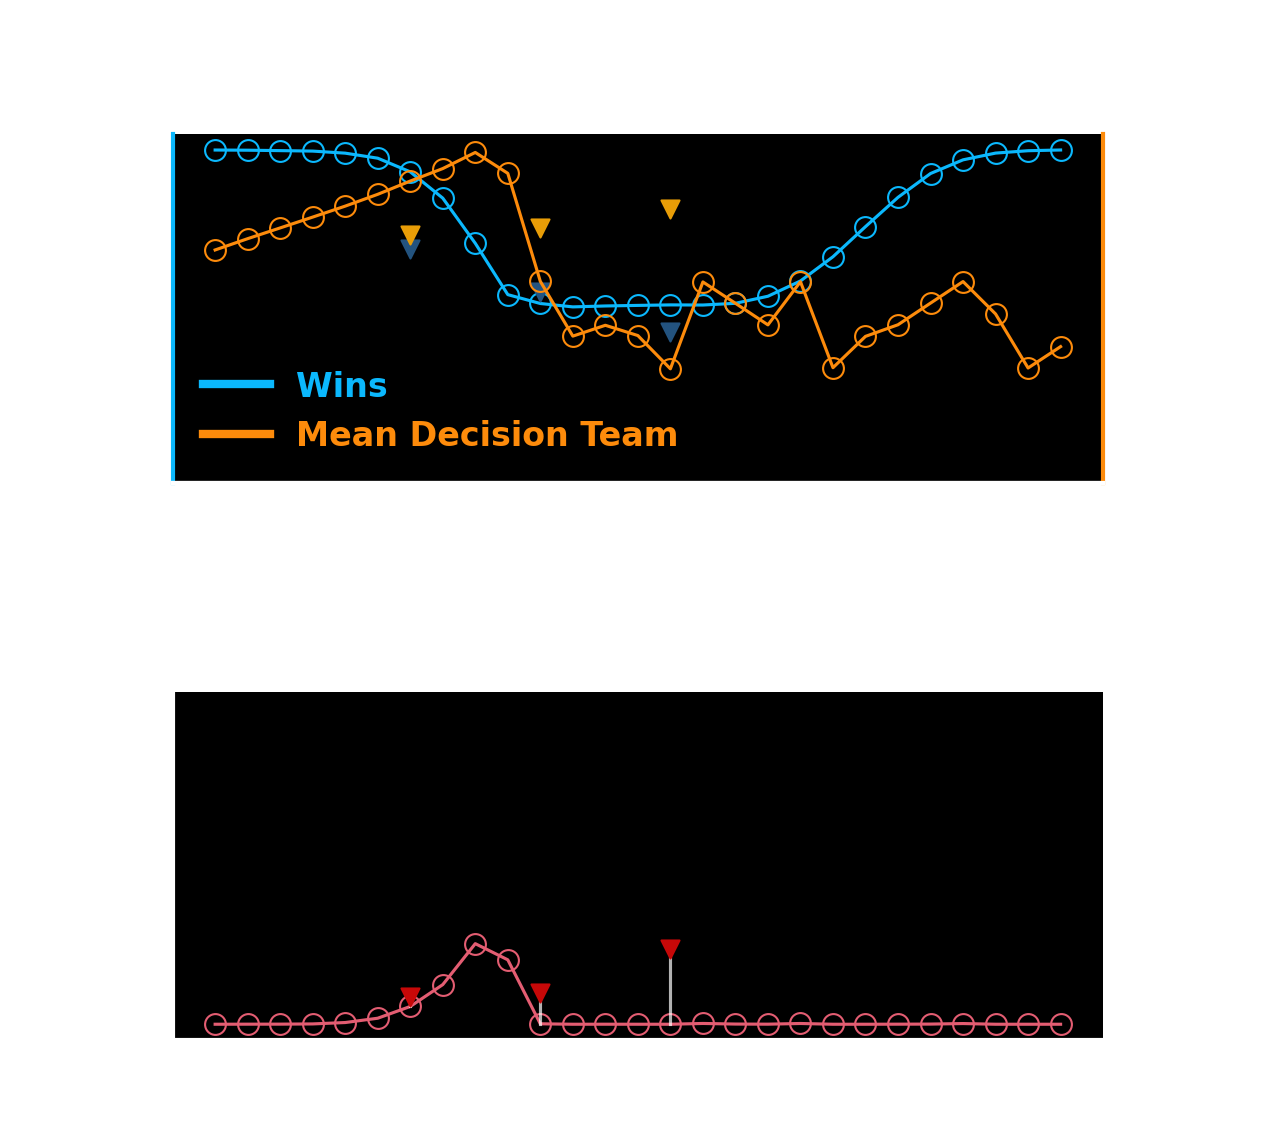

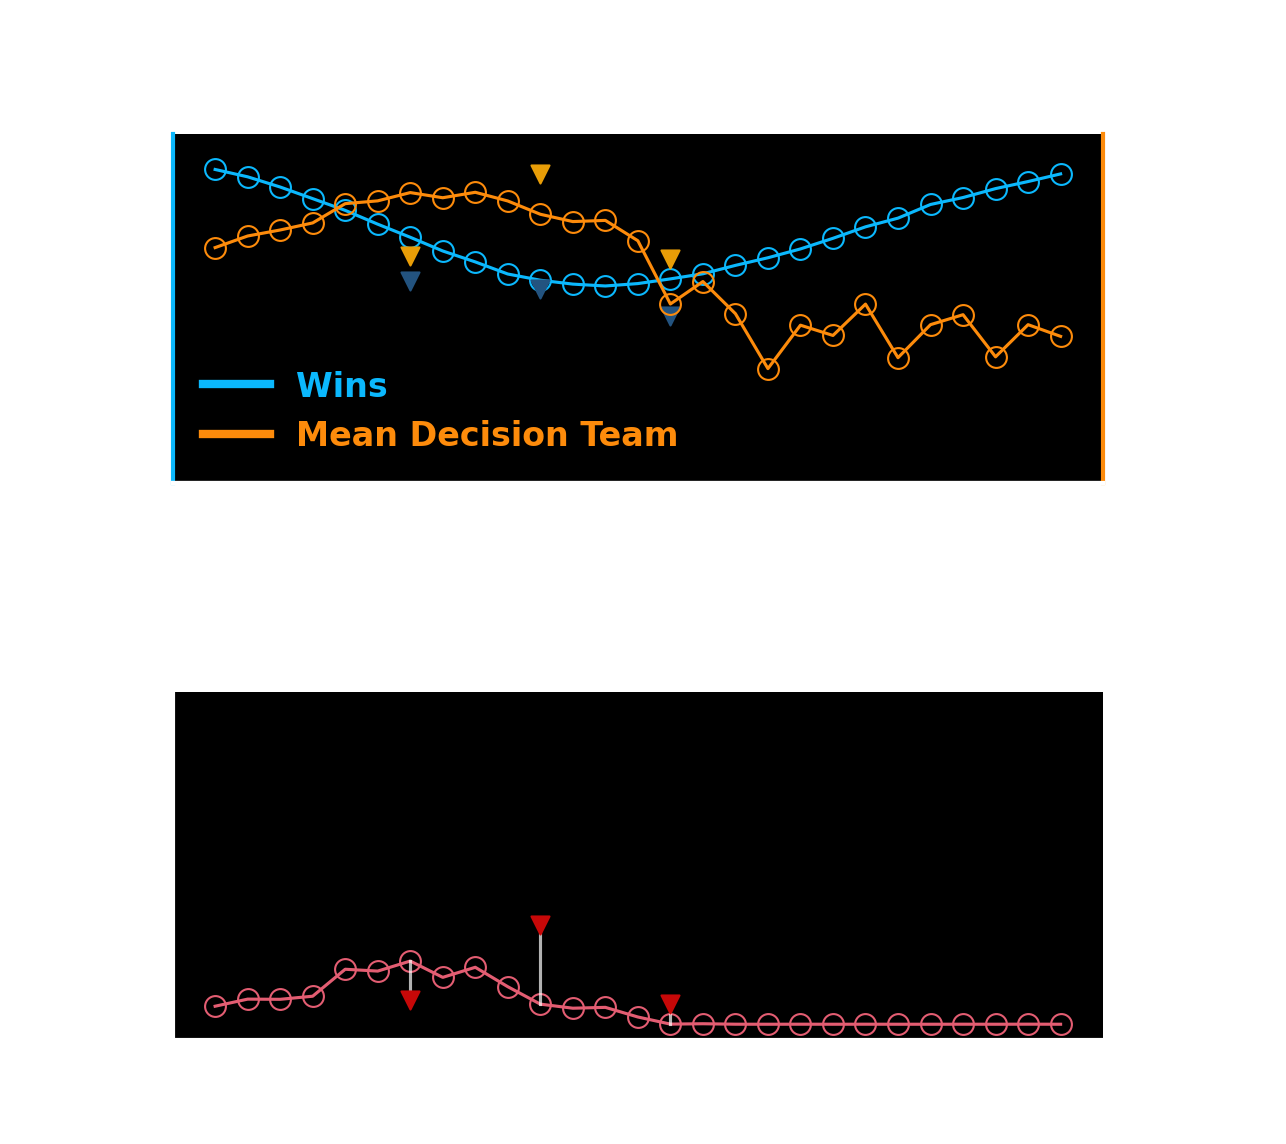

In [ ]:
# Calculate std of player
subject_number = np.arange(0,NUM_SUBJECTS)
condition_times = np.array([1000,1100,1200])


p1_std = mean_of_sd_player_reaction_time+mean_of_coincidence_timing_sd
print(f"Reaction Time Mean = {mean_of_mean_player_reaction_time}")
print(f'Overall Uncertainty = {p1_std}')
p1_std = [p1_std]
agent_std = [50,150]
figs = [] # Empty list to store figures so I can change them around on the next cell
a,b = -1,-1
for sig1 in (p1_std):
    a+=1
    for sig2 in agent_std:
        b+=1
        #%% Constant Variables
        TRIAL_TIME = 1500
        NUM_TRIALS = 10000
        REACTION_TIME = mean_of_mean_player_reaction_time - mean_of_sd_player_reaction_time
        MOVEMENT_TIME = mean_of_mean_movement_time
        AGENT_MOVEMENT_TIME = 150
        #Start and end decision time for player 1
        interval = 25
        start_time1 = 1000
        end_time1 = 1650
        total_times1 = int((end_time1 - start_time1) / interval)+1
        target_reach_means_p1 = np.zeros(total_times1)
        # Start and end decision time for player 2
        start_time = 1000
        end_time = 1650
        total_times2 = int((end_time - start_time) / interval)+1
        target_reach_means_agent = np.zeros(total_times2)
        # Creating AVERAGE decision time arrays
        # To be used in the norm.rvs
        for i in range(total_times1):
            target_reach_means_p1[i] = start_time1
            start_time1 = start_time1 + interval
        for i in range(total_times2):
            target_reach_means_agent[i] = start_time
            start_time = start_time + interval
        target_reach_means_p1 = target_reach_means_p1.astype(int)
        target_reach_means_agent = target_reach_means_agent.astype(int)
        agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME
        #Decision time storage arrays
        p1_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_task_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        p1_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        p1_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        
        #%% Run Simulation w/ SD = 100,100
        
        c=-1
        for dt_p1 in (target_reach_means_p1):
            c=c+1
            z=-1
            for dt_agent in target_reach_means_agent:
                z=z+1
                # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                # agent_task_reach_time[c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                agent_task_reach_time[c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
        p1_decision_time = p1_reach_time - MOVEMENT_TIME
        agent_decision_time = agent_task_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


        #make response time arrays
        # for dt_p1 in tqdm(target_reach_means_p1):
        #         c=c+1
        #         z=-1
        #         for dt_agent in target_reach_means_agent:
        #             z=z+1

        #-----------------------------------------------------------------------------
        p1_wins, p1_reaction_wins, p1_gamble_wins, p1_gamble_losses, agent_wins, p1_indecision, agent_indecision, \
            p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                    target_reach_means_p1, target_reach_means_agent, 
                                                                                                    p1_reach_time, agent_task_reach_time,
                                                                                                    p1_decision_time,agent_decision_time)
        # Calculate both decided wins
        p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
            calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
        # Caluclate mean decision times
        
        #%% Find optimal control policy 
        # Find average of actual decision times
        p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
        p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
        for i in range(len(target_reach_means_p1)):
            for j in range(len(target_reach_means_agent)):
                p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
        for i in range(len(target_reach_means_p1)):
            p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
            
        optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
        optimal_indecisions = np.zeros(len(target_reach_means_p1))
        optimal_wins = np.zeros(len(target_reach_means_p1))
        optimal_incorrects = np.zeros(len(target_reach_means_p1))
        perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
        for j in range(len(target_reach_means_agent)):
            max_win_index = np.argmax(p1_wins[:,j])
            optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
            optimal_indecisions[j] = p1_indecision[max_win_index,j]
            optimal_wins[j] = p1_wins[max_win_index,j]
            # optimal_incorrects[j] = p1_incorrects[max_win_index,j] Need to implement optimal incorrects
            perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
        perc_optimal_wins = optimal_wins/NUM_TRIALS*100
        perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

        # Pickle each subject
        subname = f'Sub{sub_num + 1}'
        data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
        pickle.dump(perc_optimal_wins, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_wins.pkl', 'wb'))
        pickle.dump(perc_optimal_indecisions, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_indecisions.pkl', 'wb'))
        pickle.dump(optimal_mean_decision_time, open(data_path + f'{subname}_optimal_simulation_agent_sd{sig2}_perc_optimal_mean_decision_time.pkl', 'wb'))

        # #%% All on one, with vertical lines on the selected mean decision time
        # plt.figure(dpi=125)
        # ax = plt.subplot()
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
        # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
        # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
        # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
        # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
        # ax.set_ylim(-5,105)
        # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
        # ax.set_xlabel("Opponent Mean Decision Time")
        # ax.set_ylabel(' Percentages (%)')
        # ax.spines['left'].set_color(wheel.dark_blue)
        # ax.spines['left'].set_linewidth(2)
        # ax.spines['top'].set_visible(False)

        # ax2 = ax.twinx()
        # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
        # ax2.set_yticks(np.arange(400,1600,100))
        # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
        # ax2.set_ylim(600,1400)
        # ax2.spines['right'].set_visible(True)
        # ax2.spines['right'].set_color(wheel.dark_red)
        # ax2.spines['right'].set_linewidth(2)
        # ax2.set_ylabel('Participant Mean Decision Time')
        # ax2.spines['left'].set_visible(False)
        # ax2.spines['top'].set_visible(False)
        # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
        # ax.set_title('Probabilistic Model Results')
        # labels = ['Indecisions', 'Wins','Mean Decision Time']
        # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
        # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
        # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
        # plt.show()
        
        # Plot lines with the player means as points
        index = []
        for x in condition_times:
            index.append(np.argwhere(agent_decision_means==x))
        perc_optimal_indecisions1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_indecisions) # itemgetter gets 3 specific indecies from the thing in parentheses, in this case perc_optimal_indecisions
        perc_optimal_wins1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_wins)
        optimal_mean_decision_time1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(optimal_mean_decision_time)
        if sig2 == 50:
            player_mean_decision_time1 = player_mean_decision_time[sub_num,::2] # This takes every other index, so only the 50 std ones
            perc_player_indecisions1 = perc_player_indecisions[sub_num,::2]
            perc_player_wins1 = perc_player_wins[sub_num,::2]
            print(perc_optimal_indecisions1,perc_player_indecisions1)
        else:
            perc_player_indecisions1 = perc_player_indecisions[sub_num,1::2]
            perc_player_wins1 = perc_player_wins[sub_num,1::2]
            player_mean_decision_time1 = player_mean_decision_time[sub_num,1::2] # Same as above but starts at index of 1
            
            
        plot_optimals(perc_optimal_wins,perc_optimal_indecisions,optimal_mean_decision_time,
                        perc_player_wins1,perc_player_indecisions1,player_mean_decision_time1,
                        target_reach_means_agent,condition_times,title = 'All Subjects')
        # fig,ax = plt.subplots(dpi = 125)
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions, c = wheel.dark_blue2, label = 'Indecisions')
        # ax.scatter(condition_times,perc_player_indecisions1, c = wheel.dark_blue2,alpha=0.7)    
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins, c = wheel.light_blue, label = 'Wins')
        # ax.scatter(condition_times,perc_player_wins1, c = wheel.light_blue,alpha=0.7)
        # ax.plot((condition_times,condition_times),(perc_optimal_indecisions1,perc_player_indecisions1), c= wheel.dark_blue2,alpha=0.7)
        # ax.plot((condition_times,condition_times),(perc_optimal_wins1,perc_player_wins1), c= wheel.light_blue, alpha = 0.7)
        # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
        # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
        # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
        # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
        # ax.set_ylim(-5,105)
        # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
        # ax.set_xlabel("Opponent Mean Decision Time")
        # ax.set_ylabel(' Percentages (%)')
        # ax.spines['left'].set_color(wheel.dark_blue)
        # ax.spines['left'].set_linewidth(2)
        # ax.spines['top'].set_visible(False)

        # ax2 = ax.twinx()
        # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time, c=wheel.dark_red)
        # ax2.scatter(condition_times, player_mean_decision_time1, c= wheel.dark_red, alpha = 0.7)
        # ax2.plot((condition_times,condition_times),(optimal_mean_decision_time1,player_mean_decision_time1), c= wheel.dark_red, alpha = 0.7)

        c=-1
        # for x in condition_times:
        #     c+=1
        #     index = np.argwhere(target_reach_means_agent == x)
        #     index = index[0][0]
        #     print(perc_optimal_indecisions[index],perc_optimal_wins[index],optimal_mean_decision_time[index])
        #     ax.axvline(x,perc_optimal_indecisions[index],perc_player_indecisions1[c])
        #     ax.axvline(x,perc_optimal_wins[index],perc_player_wins1[c])
        #     ax2.axvline(x,optimal_mean_decision_time[index],player_mean_decision_time1[c])
            
        # ax2.set_yticks(np.arange(400,1600,100))
        # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
        # ax2.set_ylim(600,1450)
        # ax2.spines['right'].set_visible(True)
        # ax2.spines['right'].set_color(wheel.dark_red)
        # ax2.spines['right'].set_linewidth(2)
        # ax2.set_ylabel('Participant Mean Decision Time')
        # ax2.spines['left'].set_visible(False)
        # ax2.spines['top'].set_visible(False)
        # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
        # ax.set_title(f'Probabilistic Model Results \n Sub{sub_num+1}, Agent STD = {sig2}')
        # labels = ['Indecisions', 'Wins','Mean Decision Time']
        # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
        # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3, columnspacing=2)
        # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{player_reaction_time}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
        # plt.show()
        # figs.append(fig)
        
        
    
    
    #plot_list.append(ax)

### Plot Data and Optimal Box Plots

### Bootstrapping?

#### Draw from distribution of reactions and such and then make boxplots with numerical optimals

Bootstrap mean reaction time and standard deviation
Idea is to get bootstrapped mean and bootstrapped sd (not sd of means) of reaction time, movement time, react+move time, timing sd and use these to draw from normal distributions to create mock participants

In [ ]:
boot_n = 100000
mean_player_reaction_time_boot = np.zeros(boot_n)
sd_player_reaction_time_boot = np.zeros(boot_n)
mean_movement_time_boot = np.zeros(boot_n)
sd_movement_time_boot = np.zeros(boot_n)

mean_reaction_movement_time_boot = np.zeros(boot_n)
sd_reaction_movement_time_boot = np.zeros(boot_n)
sd_timing_time_boot = np.zeros(boot_n)

for i in range(boot_n):
    rt_mean_b = np.random.choice(player_reaction_time_mean, size = len(player_reaction_time_mean),replace=True)
    rt_sd_b = np.random.choice(player_reaction_time_sd, size = len(player_reaction_time_sd),replace=True)
    mt_mean_b = np.random.choice(movement_time_mean, size = len(movement_time_mean),replace=True)
    mt_sd_b = np.random.choice(movement_time_sd, size = len(movement_time_sd),replace=True)
    rmt_mean_b = np.random.choice(reaction_movement_time_mean, size = len(reaction_movement_time_mean),replace=True)
    rmt_sd_b = np.random.choice(reaction_movement_time_sd, size = len(reaction_movement_time_sd),replace=True)
    timing_sd_b = np.random.choice(timing_reach_time_sd, size = len(timing_reach_time_sd), replace=True)
    
    mean_player_reaction_time_boot[i] = np.mean(rt_mean_b)
    sd_player_reaction_time_boot[i] = np.mean(rt_sd_b)
    mean_movement_time_boot[i] = np.mean(mt_mean_b)
    sd_movement_time_boot[i] = np.mean(mt_sd_b)
    mean_reaction_movement_time_boot[i] = np.mean(rmt_mean_b)
    sd_reaction_movement_time_boot[i] = np.mean(rmt_sd_b)
    sd_timing_time_boot = np.mean(timing_sd_b)
    
    

NameError: name 'reaction_movement_time_mean' is not defined

In [ ]:
bs_mean_mean_reaction_movement_time = np.mean(mean_reaction_movement_time_boot)
bs_sd_mean_reaction_movement_time = np.std(mean_reaction_movement_time_boot)
bs_mean_sd_reaction_movement_time = np.mean(sd_reaction_movement_time_boot)
bs_sd_sd_reaction_movement_time = np.std(sd_reaction_movement_time_boot)

In [ ]:
bs_mean_mean_player_reaction_time = np.mean(mean_player_reaction_time_boot)
bs_sd_mean_player_reaction_time = np.std(mean_player_reaction_time_boot)
bs_mean_sd_player_reaction_time = np.mean(sd_player_reaction_time_boot) # Not used
bs_sd_sd_player_reaction_time = np.std(sd_player_reaction_time_boot) # Not Used

bs_mean_mean_movement_time = np.mean(mean_movement_time_boot)
bs_sd_mean_movement_time = np.std(mean_movement_time_boot)
bs_mean_sd_movement_time = np.mean(sd_movement_time_boot) # Not used
bs_sd_sd_movement_time = np.std(sd_movement_time_boot) # Not used

bs_mean_mean_reaction_movement_time = np.mean(mean_reaction_movement_time_boot)
bs_sd_mean_reaction_movement_time = np.std(mean_reaction_movement_time_boot)
bs_mean_sd_reaction_movement_time = np.mean(sd_reaction_movement_time_boot)
bs_sd_sd_reaction_movement_time = np.std(sd_reaction_movement_time_boot)

bs_mean_sd_timing_time = np.mean(sd_timing_time_boot)
bs_sd_sd_timing_time = np.std(sd_timing_time_boot)

Run simulation with bootstrapped data

In [ ]:
subject_number = np.arange(0,1)
condition_times = np.array([1000,1100,1200])
print(f"Reaction Time Mean = {mean_of_mean_player_reaction_time}")
print(f'Overall Uncertainty = {p1_std}')
update_params('w')
figs = [] # Empty list to store figures so I can change them around on the next cell

TRIAL_TIME = 1500
NUM_TRIALS = 10000
AGENT_MOVEMENT_TIME = 150 
agent_std = [50,150]
#Decision time storage arrays
p1_reach_time= np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_task_reach_time = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
p1_decision_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_decision_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
p1_both_decided_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_both_decided_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))


 #Start and end decision time for player 1
interval = 25
start_time1 = 1000
end_time1 = 1650
total_times1 = int((end_time1 - start_time1) / interval)+1
target_reach_means_p1 = np.zeros((total_times1))
# Creating AVERAGE decision time arrays
# To be used in the norm.rvs
for i in range(total_times1):
    target_reach_means_p1[i] = start_time1
    start_time1 = start_time1 + interval
target_reach_means_p1 = target_reach_means_p1.astype(int)
target_reach_means_agent = np.array(condition_times+AGENT_MOVEMENT_TIME, dtype = int)
agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME

#%% Create ARRAYS
# For finding average of actual decision times
p1_avg_dt = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
p1_avg_dt_final = np.zeros((len(agent_std),len(target_reach_means_p1)))
# For finding optimals 
optimal_mean_decision_time = np.zeros((len(agent_std),len(target_reach_means_p1)))
optimal_indecisions = np.zeros((len(agent_std),len(target_reach_means_p1)))
optimal_wins = np.zeros((len(agent_std),len(target_reach_means_p1)))
perc_optimal_both_decided_wins = np.zeros((len(agent_std),len(target_reach_means_p1)))

# Get total uncertainty, which is reaction+movement sd added to timing sd
p1_std = [np.random.normal(bs_mean_sd_reaction_movement_time + bs_mean_sd_timing_time, bs_sd_sd_reaction_movement_time + bs_sd_sd_timing_time)]
a,b=-1,-1
for sig1 in (p1_std):
    a+=1
    for sig2 in agent_std:
        b+=1
        #%% Select reaction and movement time based on bootstrapped means and sd from data
        player_reaction_time = np.random.normal(bs_mean_mean_player_reaction_time, bs_sd_mean_player_reaction_time)
        MOVEMENT_TIME = np.random.normal(bs_mean_mean_movement_time, bs_sd_mean_movement_time)            
        
        # Get player and agent reach times and decision time from normal distribution 
        c=-1
        for dt_p1 in (target_reach_means_p1):
            c=c+1
            z=-1
            for dt_agent in target_reach_means_agent:
                z=z+1
                # p1_reach_time[n,c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                # agent_task_reach_time[n,c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                p1_reach_time[b,c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS) 
                agent_task_reach_time[b,c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
        p1_decision_time = p1_reach_time - MOVEMENT_TIME
        agent_decision_time = agent_task_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


        #make response time arrays
        # for dt_p1 in tqdm(target_reach_means_p1):
        #         c=c+1
        #         z=-1
        #         for dt_agent in target_reach_means_agent:
        #             z=z+1

        #-----------------------------------------------------------------------------
        p1_wins, agent_wins, p1_indecision, agent_indecision, \
            p1_reach_time, agent_task_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data(TRIAL_TIME, NUM_TRIALS, player_reaction_time,MOVEMENT_TIME,NUM_SUBJECTS,
                                                                                                                            agent_std,
                                                                                                                            target_reach_means_p1, target_reach_means_agent, 
                                                                                                                            p1_reach_time,agent_task_reach_time,
                                                                                                                            p1_decision_time,agent_decision_time,std_number = b)
        # # Calculate both decided wins
        # p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
        #     calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
        # Caluclate mean decision times
        
        #%% Find optimal control policy 
        # Find average of actual decision times
        print(p1_wins)
        for i in range(len(target_reach_means_p1)):
            for j in range(len(target_reach_means_agent)):
                p1_avg_dt[b,i,j] = np.mean(p1_decision_time[b,i,j,:])
        for i in range(len(target_reach_means_p1)):
            p1_avg_dt_final[b,i] = np.mean(p1_avg_dt[b,i,:])  
        for i in range(len(target_reach_means_agent)):
            max_win_index = np.argmax(p1_wins[b,:,i])
            optimal_mean_decision_time[b,i] = p1_avg_dt[max_win_index,i]
            optimal_indecisions[b,i] = p1_indecision[max_win_index,i]
            optimal_wins[b,i] = p1_wins[max_win_index,i]
            perc_optimal_both_decided_wins[b,i] = p1_perc_both_decided_wins[max_win_index,i]
    perc_optimal_wins = optimal_wins/NUM_TRIALS*100
    perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

Reaction Time Mean = 269.685
Overall Uncertainty = [134.21268293693305]


c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'agent_std' of function 'Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_18216\4063685051.py", line 3:
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, 
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(27,)
[[[4.921e+03 4.921e+03 4.921e+03]
  [5.006e+03 5.006e+03 5.006e+03]
  [5.027e+03 5.027e+03 5.027e+03]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 7.890e+02]
  [7.890e+02 7.890e+02 1.020e+02]
  [1.020e+02 1.020e+02 4.000e+00]
  [4.000e+00 4.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 4.766e+03]
  [4.766e+03 4.766e+03 4.962e+03]
  [4.962e+03 4.962e+03 5.044e+03]
  [5.044e+03 5.044e+03 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 5.016e+03 5.016e+03]
  [5.016e+03 5.000e+03 5.000e+03]
  [5.018e+03 5.056e+03 5.056e+03]
  [5.038e+03 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]]

 [[5.046e+03 5.046e+03 5.046e+03]
  [4.966e+03 4.966e+03 4.966e+03]
  [4.9

IndexError: index 14 is out of bounds for axis 0 with size 2

: 